# Fase 3 (Parte 2) – Correciones y Limpieza de los datos

**Importante** si bien se presenta código en este notebook es más bien para documentar algunos procesos que, como equipo, realizamos. Por lo que por medio de pipelines, ejecutando **Kedro Run**, se ejecuta toda la peparación y limpieza que se ve aquí junto a la unión de los Dataset's para posteriormente verlos en el DAG ejecutando, por consola de visual studio code, **Kedro viz**.

In [1]:
# Carga de contexto y librerias para el notebook :D
%load_ext kedro.ipython
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


////////////////AJUSTES PARA MODELOS DE CLASIFICACIÓN ///////////////////////////////////////////////////

Verificación inicial de las variables en 'PRI_FULL'

In [2]:
df = catalog.load("PRI_full")   # lee el dataset del catálogo
list(df.columns)  

[10/22/25 17:31:48] INFO     Loading data from PRI_full (ParquetDataset)...                    ]8;id=996960;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=145669;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\


[
    'TransactionID',
    'CustomerID',
    'CustLocation',
    'TransactionDate',
    'TransactionTime',
    'TransactionAmount (INR)',
    'txn_count',
    'total_spent',
    'avg_spent',
    'max_spent',
    'avg_balance',
    'first_txn_date',
    'last_txn_date',
    'recency_days',
    'tenure_days',
    'txn_per_day',
    'Recency',
    'Frequency',
    'Monetary',
    'RFM Score',
    'Segment_Final'
]

In [4]:
# =============================================
# 🔍 COMPARAR TRANSACCIONES ENTRE DOS DATASETS
# =============================================
import pandas as pd

# --- 1. Cargar ambos datasets ---
# Ajusta las rutas si están en otra carpeta
fraud_df = catalog.load("fraud_dataset")
pri_full_df = catalog.load("PRI_full")

# --- 2. Mostrar estructura básica ---
print("Dataset FRAUD:")
print("Shape:", fraud_df.shape)
print("Columnas:", fraud_df.columns.tolist(), "\n")

print("Dataset PRI_FULL:")
print("Shape:", pri_full_df.shape)
print("Columnas:", pri_full_df.columns.tolist(), "\n")

# --- 3. Identificar columnas comunes ---
common_cols = list(set(fraud_df.columns).intersection(set(pri_full_df.columns)))
print("✅ Columnas comunes encontradas:", common_cols, "\n")

# --- 4. Si existe TransactionID, comparar coincidencias ---
if "TransactionID" in common_cols:
    merged = pri_full_df.merge(fraud_df, on="TransactionID", how="inner")
    print(f"🔗 Transacciones en común: {len(merged)}")
    print(f"🔸 Total en FRAUD: {len(fraud_df)}")
    print(f"🔸 Total en PRI_FULL: {len(pri_full_df)}")

    # --- 5. Revisar si las del dataset FRAUD están incluidas en PRI_FULL ---
    if len(merged) == len(fraud_df):
        print("\n✅ El dataset FRAUD está completamente contenido en PRI_FULL (solo fraudes).")
    elif len(merged) == 0:
        print("\n⚠️ No se encontraron coincidencias. Verifica la columna TransactionID o el formato.")
    else:
        print("\n🟡 El dataset FRAUD comparte algunas transacciones con PRI_FULL, pero no todas.")

    # --- 6. (Opcional) Revisar proporción de fraudes ---
    if "is_fraud" in fraud_df.columns:
        fraud_ratio = fraud_df["is_fraud"].mean() * 100
        print(f"\n📊 Porcentaje de transacciones marcadas como fraude: {fraud_ratio:.2f}%")
else:
    print("⚠️ No hay columna 'TransactionID' común entre los datasets. Usa otra columna clave para comparar.")


[10/22/25 16:34:52] INFO     Loading data from fraud_dataset (CSVDataset)...                   ]8;id=511736;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=56781;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from PRI_full (ParquetDataset)...                    ]8;id=767149;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=59727;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

Dataset FRAUD:
Shape: (9843, 22)
Columnas: ['Unnamed: 0', 'TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance', 'TransactionDate', 'TransactionTime', 'TransactionAmount (INR)', 'Age', 'AmountZScoreByLocation', 'DayOfWeek', 'IsWeekend', 'IsHoliday', 'TimeOfDay', 'IsLateNight', 'TimeSinceLastTxn', 'TxnCountInLast24Hours', 'IsAnomaly', 'RiskScore', 'Segment'] 

Dataset PRI_FULL:
Shape: (984240, 21)
Columnas: ['TransactionID', 'CustomerID', 'CustLocation', 'TransactionDate', 'TransactionTime', 'TransactionAmount (INR)', 'txn_count', 'total_spent', 'avg_spent', 'max_spent', 'avg_balance', 'first_txn_date', 'last_txn_date', 'recency_days', 'tenure_days', 'txn_per_day', 'Recency', 'Frequency', 'Monetary', 'RFM Score', 'Segment_Final'] 

✅ Columnas comunes encontradas: ['CustLocation', 'TransactionTime', 'TransactionID', 'TransactionDate', 'CustomerID', 'TransactionAmount (INR)'] 

🔗 Transacciones en común: 9843
🔸 Total en FRAUD: 9843
🔸 Total en PRI_

Como respuesta podemos ver que el dataset 'PRI_FULL' si contiene las transacciones fraudulentas, pero si revisamos el dataset 'fraud_dataset' podemos observar que tiene algunas variables de inter'es para el analisis.

In [5]:
df = catalog.load("fraud_dataset")   # lee el dataset del catálogo
list(df.columns)  

[10/22/25 16:37:50] INFO     Loading data from fraud_dataset (CSVDataset)...                   ]8;id=711280;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=599948;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\


[
    'Unnamed: 0',
    'TransactionID',
    'CustomerID',
    'CustomerDOB',
    'CustGender',
    'CustLocation',
    'CustAccountBalance',
    'TransactionDate',
    'TransactionTime',
    'TransactionAmount (INR)',
    'Age',
    'AmountZScoreByLocation',
    'DayOfWeek',
    'IsWeekend',
    'IsHoliday',
    'TimeOfDay',
    'IsLateNight',
    'TimeSinceLastTxn',
    'TxnCountInLast24Hours',
    'IsAnomaly',
    'RiskScore',
    'Segment'
]

Entre ellas podemos observar:
'IsAnomaly' - Esta variable nos dice si es fraudulenta o no ........
'IsWeekend' - Esta variable dice si es fin de semana
'IsHoliday' - Esta variable dice si es feriado, por el momento no podemos determinarla en el dataset porque es un dataset de otro país, descartada
'DayOfWeek' - Dia de la semana, también puede ser un punto de interés
'TimeOfDay' - A que momento del dia ocurre que también podría ser un aporte
'AmountZScoreByLocation' - Según los montos en zonas simkilares podría ser muy relevante, quizás en zonas determinadas el monto es inusual
'IsLateNight' - Otra variable de tiempo al igual que TimeOfDay podría ser un punto fuerte


A continuación intentamos replicar algunas de estas variables en el dataset principal 'PRI_FULL' para dar más información al momento de entrenar los modelos.

In [6]:
# === 1️⃣ Cargar dataset base ===
df = catalog.load("PRI_full").copy()

# --- Asegurar formato de fechas y horas ---
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'], format='%H:%M:%S', errors='coerce')

# =========================================================
# === 2️⃣ Variables temporales y de contexto ===============
# =========================================================

# Día de la semana
df['DayOfWeek'] = df['TransactionDate'].dt.day_name()

# Fin de semana
df['IsWeekend'] = df['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)

# Hora del día
df['hour'] = df['TransactionTime'].dt.hour
df['IsLateNight'] = ((df['hour'] >= 23) | (df['hour'] <= 5)).astype(int)
df['TimeOfDay'] = pd.cut(
    df['hour'], bins=[0,6,12,18,24],
    labels=['Night','Morning','Afternoon','Evening'],
    right=False, include_lowest=True
)
# =========================================================
# === 3️⃣ Variables de comportamiento ======================
# =========================================================

# Monto Z-Score por ubicación
df['AmountZScoreByLocation'] = (
    df.groupby('CustLocation')['TransactionAmount (INR)']
      .transform(lambda x: (x - x.mean()) / (x.std() + 1e-9))
)

# Días desde última transacción por cliente
df = df.sort_values(['CustomerID', 'TransactionDate'])
df['TimeSinceLastTxn'] = (
    df.groupby('CustomerID')['TransactionDate']
      .diff().dt.total_seconds() / (60*60*24)
).fillna(0)

# --- Simplificación robusta ---
# Si la diferencia entre esta y la anterior <= 24h, marcamos como 1
df['TxnCountInLast24Hours'] = (
    (df.groupby('CustomerID')['TransactionDate']
       .diff().dt.total_seconds() / 3600 <= 24)
    .astype(int)
    .fillna(0)
)

# =========================================================
# === 4️⃣ Variables de riesgo ==============================
# =========================================================

# Riesgo basado en monto relativo al promedio histórico del cliente
df['RiskScore'] = np.where(
    df['TransactionAmount (INR)'] > (
        df['TransactionAmount (INR)'].mean() +
        2 * df['TransactionAmount (INR)'].std()
    ),
    1, 0
)

# Anomalía simple (monto alto + transacción nocturna)
df['IsAnomaly'] = ((df['RiskScore'] == 1) & (df['IsLateNight'] == 1)).astype(int)

# =========================================================
# === 5️⃣ Limpieza y validación ============================
# =========================================================
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna({
    'AmountZScoreByLocation': 0,
    'TimeSinceLastTxn': 0,
    'TxnCountInLast24Hours': 0,
    'RiskScore': 0,
    'IsAnomaly': 0
})

print("✅ Nuevas columnas creadas:")
print([col for col in df.columns if col in [
    'DayOfWeek','IsWeekend','IsLateNight','TimeOfDay',
    'AmountZScoreByLocation','TimeSinceLastTxn','TxnCountInLast24Hours','RiskScore','IsAnomaly'
]])
print("\nShape final:", df.shape)

[10/22/25 16:38:05] INFO     Loading data from PRI_full (ParquetDataset)...                    ]8;id=528908;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=977203;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

[10/22/25 16:38:09] WARNING  C:\Users\Kevin\AppData\Local\Temp\ipykernel_18036\2741150868.py:32:    ]8;id=99494;file://C:\Python313\Lib\warnings.py\warnings.py]8;;\:]8;id=392331;file://C:\Python313\Lib\warnings.py#110\110]8;;\
                             FutureWarning: The default of observed=False is deprecated and will be                
                             changed to True in a future version of pandas. Pass observed=False to                 
                             retain current behavior or observed=True to adopt the future default                  
                             and silence this warning.                                                             
                               df.groupby('CustLocation')['TransactionAmount (INR)']                               
                                                                                                                   

✅ Nuevas columnas creadas:
['DayOfWeek', 'IsWeekend', 'IsLateNight', 'TimeOfDay', 'AmountZScoreByLocation', 'TimeSinceLastTxn', 'TxnCountInLast24Hours', 'RiskScore', 'IsAnomaly']

Shape final: (984240, 31)


Ya con las variables agregadas necesitamos saber si son fraude, por lo que añadimos la etiqueta a partir de las transacciones existentes en el dataset fraud

In [7]:
#Crear etiqueta de fraude 1 Si esta en el fraud_Datset y 0 si no :p

df_full = catalog.load("PRI_full")
df_fraud = catalog.load("fraud_dataset")

# Etiqueta de fraude
df_full['is_fraud'] = df_full['TransactionID'].isin(df_fraud['TransactionID']).astype(int)

print(df_full['is_fraud'].value_counts())

[10/22/25 16:39:59] INFO     Loading data from PRI_full (ParquetDataset)...                    ]8;id=699543;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=793659;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

[10/22/25 16:40:00] INFO     Loading data from fraud_dataset (CSVDataset)...                   ]8;id=415;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=863183;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

is_fraud
0    974397
1      9843
Name: count, dtype: int64


**//////////////////////////////////////////////////////////////////////////////////////////////////////////**

# Manejo de Outliders 

Cargamos los dataset con los que trabajaremos

In [6]:
fraud = pd.read_csv('../data/01_raw/fraud_dataset.csv')
rfm = pd.read_csv('../data/01_raw/RFM.csv')
cleaned = pd.read_csv('../data/01_raw/cleaned_dataset.csv')
agg = pd.read_csv('../data/01_raw/customer_agg.csv')

#### 1) fraud_dataset

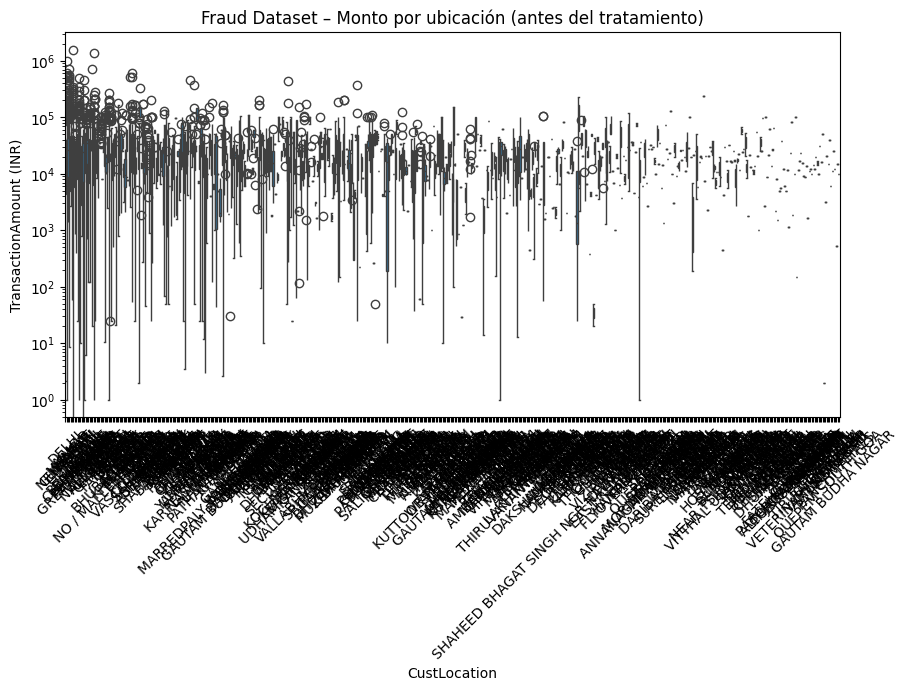

In [11]:
# Como se ve actualmente
plt.figure(figsize=(10,5))
sns.boxplot(x='CustLocation', y='TransactionAmount (INR)', data=fraud)
plt.yscale('log')  # log para ver mejor la escala
plt.title('Fraud Dataset – Monto por ubicación (antes del tratamiento)')
plt.xticks(rotation=45)
plt.show()

Usaremos el método IQR (rango intercuartílico) para recortar los valores extremos.
Esto no elimina filas, solo “recorta” valores exagerados dentro de un rango razonable.

In [13]:
# Copia para comparar después
fraud_before = fraud.copy()

# Calcular límites IQR globales
Q1 = fraud['TransactionAmount (INR)'].quantile(0.25)
Q3 = fraud['TransactionAmount (INR)'].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

print(f"Límite inferior: {lower_limit:.2f}")
print(f"Límite superior: {upper_limit:.2f}")

# Capping: limitar valores extremos dentro de esos límites
fraud['TransactionAmount (INR)'] = fraud['TransactionAmount (INR)'].clip(lower=lower_limit, upper=upper_limit)


Límite inferior: -40002.34
Límite superior: 90351.80


Vizualizamos un antes y después del tratamiento de Outliers

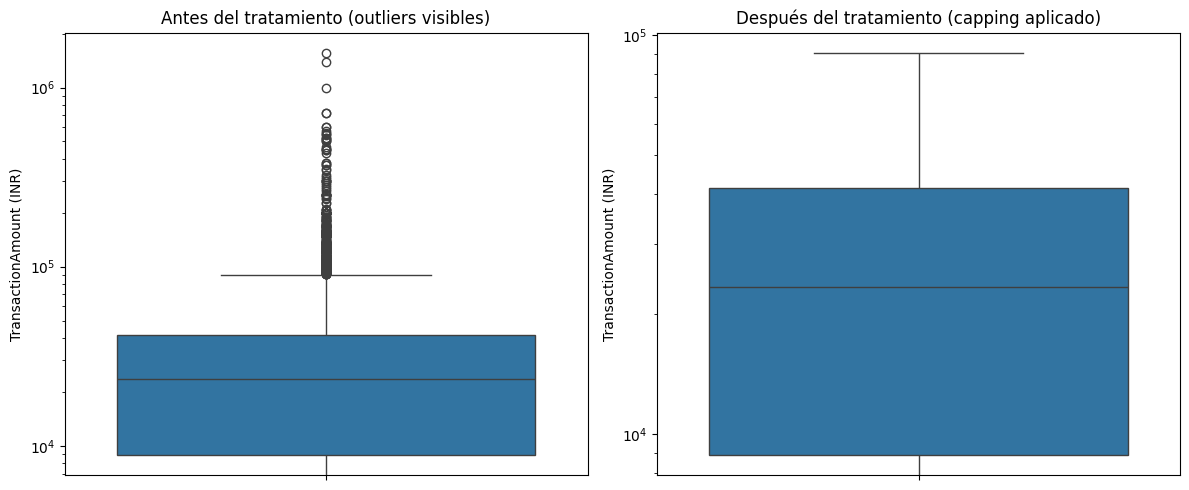

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.boxplot(y=fraud_before['TransactionAmount (INR)'], ax=axes[0])
axes[0].set_title("Antes del tratamiento (outliers visibles)")
axes[0].set_yscale('log')

sns.boxplot(y=fraud['TransactionAmount (INR)'], ax=axes[1])
axes[1].set_title("Después del tratamiento (capping aplicado)")
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()


El capping con IQR es un método adecuado en esta etapa, ya que controla los valores extremos sin eliminar la evidencia 
de posibles fraudes, manteniendo la integridad de los patrones de comportamiento que el modelo deberá aprender más adelante.

#### 2) RFM (Monetary, Frequency y Recency)

Se revisar la distribución de las tres variables principales

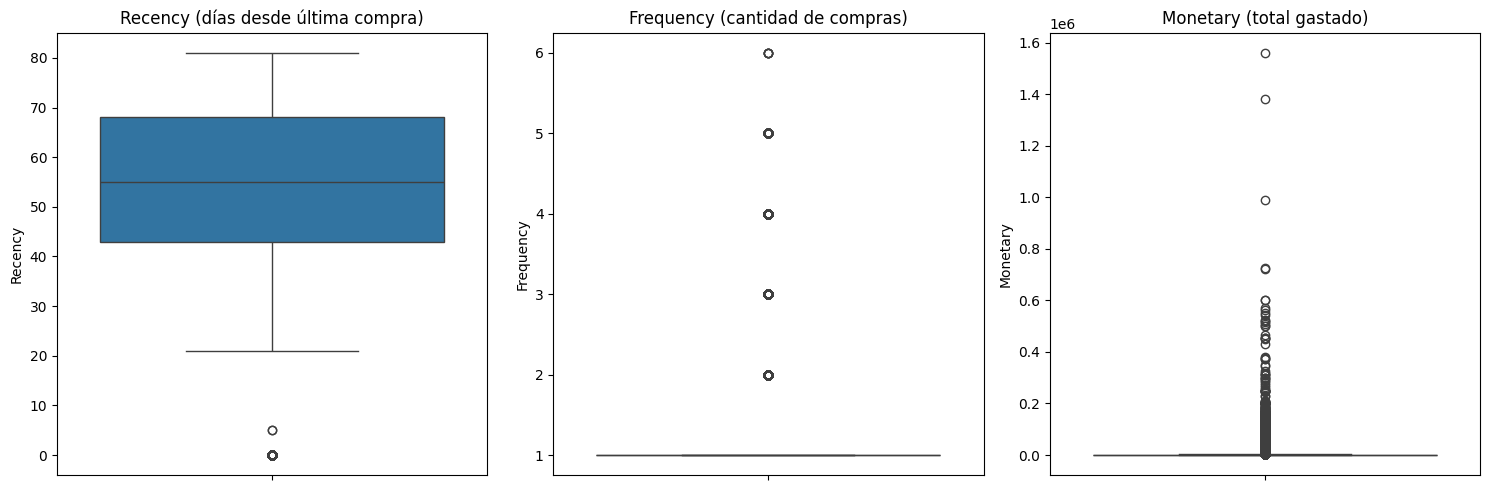

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(y=rfm['Recency'], ax=axes[0])
axes[0].set_title('Recency (días desde última compra)')

sns.boxplot(y=rfm['Frequency'], ax=axes[1])
axes[1].set_title('Frequency (cantidad de compras)')

sns.boxplot(y=rfm['Monetary'], ax=axes[2])
axes[2].set_title('Monetary (total gastado)')

plt.tight_layout()
plt.show()


Se aplica capping por IQR a cada variable numérica

In [22]:
rfm_before = rfm.copy()

def cap_iqr(df, col, k=1.5):
    """Capea valores fuera del rango intercuartílico (IQR)."""
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    df[col] = np.clip(df[col], lower, upper)
    return df, (lower, upper)

# Aplicar tratamiento diferenciado
rfm, limits_rec = cap_iqr(rfm, 'Recency', k=2.0)     # leve
rfm, limits_freq = cap_iqr(rfm, 'Frequency', k=1.5)  # moderado
rfm, limits_mon = cap_iqr(rfm, 'Monetary', k=1.0)    # más estricto

print("Límites aplicados:")
print("Recency:", limits_rec)
print("Frequency:", limits_freq)
print("Monetary:", limits_mon)



Límites aplicados:
Recency: (np.float64(-7.0), np.float64(118.0))
Frequency: (np.float64(1.0), np.float64(1.0))
Monetary: (np.float64(-1012.0), np.float64(2618.0))


Se vizualizan resultados

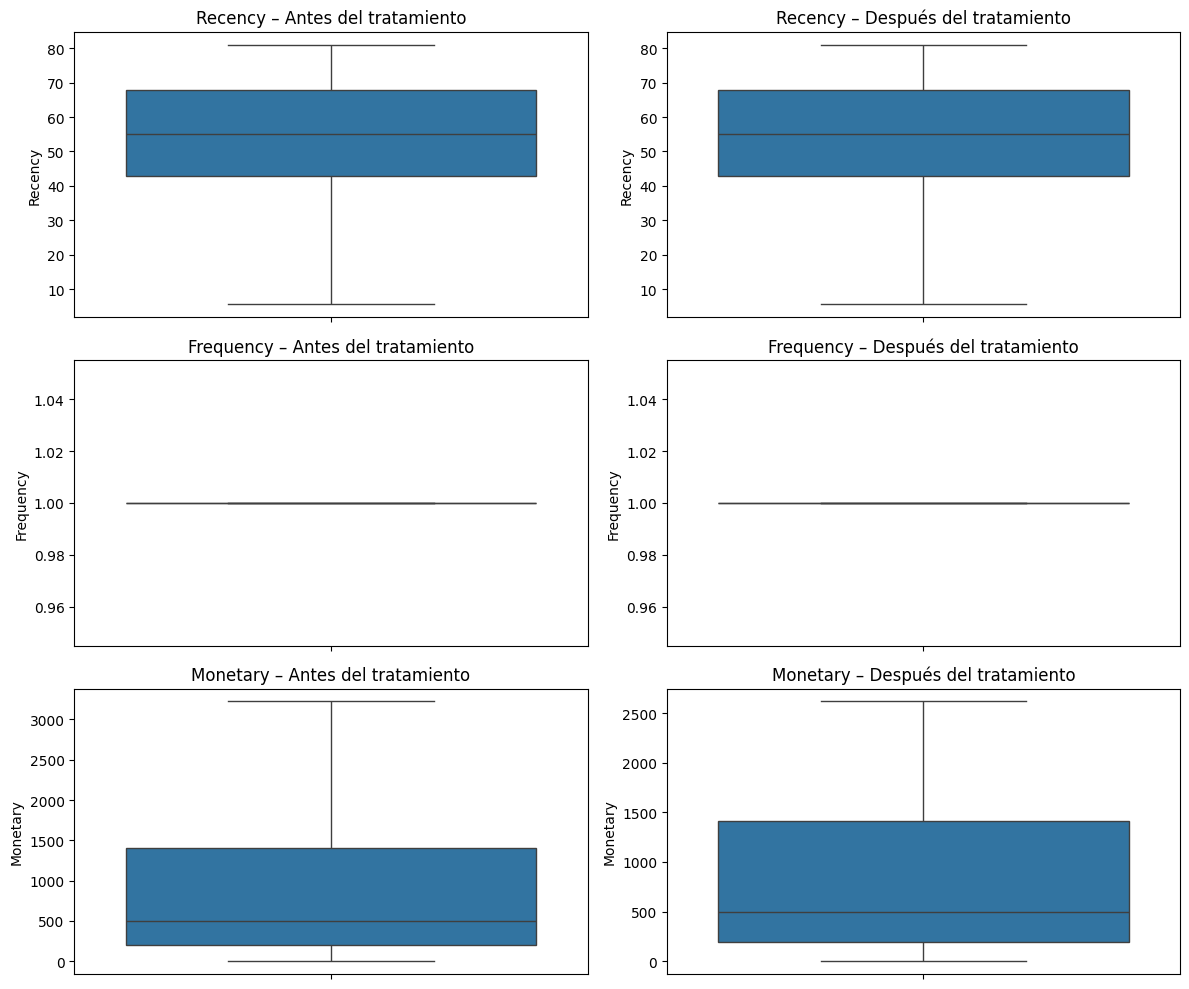

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

cols = ['Recency', 'Frequency', 'Monetary']
for i, col in enumerate(cols):
    sns.boxplot(y=rfm_before[col], ax=axes[i, 0])
    axes[i, 0].set_title(f"{col} – Antes del tratamiento")
    sns.boxplot(y=rfm[col], ax=axes[i, 1])
    axes[i, 1].set_title(f"{col} – Después del tratamiento")
plt.tight_layout()
plt.show()


Analizar cuántos valores fueron recortados posterior al tratamiento

In [24]:
for col in ['Recency', 'Frequency', 'Monetary']:
    capped = (rfm_before[col] != rfm[col]).sum()
    pct = 100 * capped / len(rfm)
    print(f"{col}: {capped} valores ajustados ({pct:.2f}%)")


Recency: 0 valores ajustados (0.00%)
Frequency: 0 valores ajustados (0.00%)
Monetary: 109416 valores ajustados (13.05%)


El dataset RFM quedó limpio y representativo del comportamiento real de los clientes.  
La variable *Frequency* no aporta información en esta versión del dataset, pero la estructura RFM completa se mantiene para futuras actualizaciones con datos históricos.  
En conjunto, este tratamiento garantiza una base de datos más confiable y equilibrada para análisis posteriores.

#### 3) cleaned_dataset 

In [40]:
print("Shape:", cleaned.shape)
cleaned.info()

Shape: (984247, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984247 entries, 0 to 984246
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   TransactionID            984247 non-null  object 
 1   CustomerID               984247 non-null  object 
 2   CustomerDOB              984247 non-null  object 
 3   CustGender               984247 non-null  object 
 4   CustLocation             984240 non-null  object 
 5   CustAccountBalance       984247 non-null  float64
 6   TransactionDate          984247 non-null  object 
 7   TransactionTime          984247 non-null  object 
 8   TransactionAmount (INR)  984247 non-null  float64
 9   Age                      984247 non-null  float64
dtypes: float64(3), object(7)
memory usage: 75.1+ MB


In [36]:
# Seleccionamos las variables a mejorar

num_cols = ['CustAccountBalance', 'TransactionAmount (INR)', 'Age']
cleaned[num_cols].describe()

,CustAccountBalance,TransactionAmount (INR),Age
count,9.842470e+05,9.842470e+05,984247.000000
mean,1.037604e+05,1.440537e+03,30.852597
std,8.089044e+05,6.083278e+03,8.791230
min,0.000000e+00,0.000000e+00,7.000000
25%,4.586680e+03,1.500000e+02,25.000000
50%,1.602264e+04,4.300000e+02,29.000000
75%,5.321634e+04,1.119045e+03,34.000000
max,1.150355e+08,1.560035e+06,106.000000


Se visualizan los boxplots iniciales

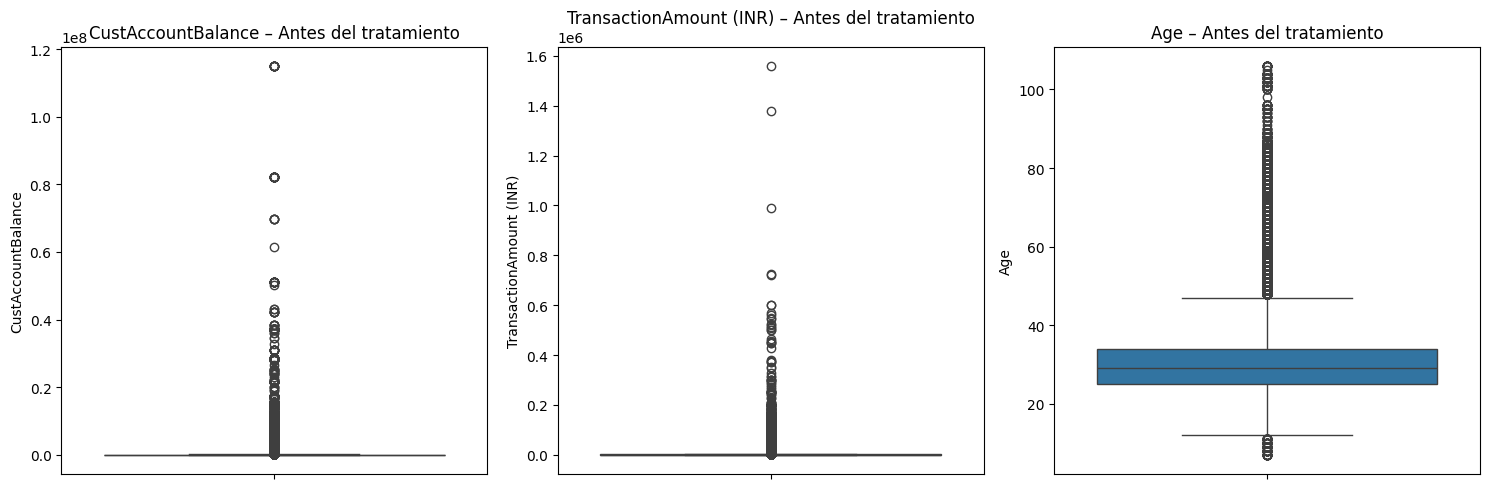

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, col in enumerate(num_cols):
    sns.boxplot(y=cleaned[col], ax=axes[i])
    axes[i].set_title(f"{col} – Antes del tratamiento")
plt.tight_layout()
plt.show()


Aplicar capping IQR solo en esas tres columnas

In [38]:
cleaned_before = cleaned.copy()

def cap_iqr(df, col, k=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k*IQR
    upper = Q3 + k*IQR
    df[col] = np.clip(df[col], lower, upper)
    return df, (lower, upper)

for col in num_cols:
    cleaned, limits = cap_iqr(cleaned, col)
    print(f"{col}: límites aplicados {limits}")


CustAccountBalance: límites aplicados (np.float64(-68357.81), np.float64(126160.82999999999))
TransactionAmount (INR): límites aplicados (np.float64(-1303.5675), np.float64(2572.6125))
Age: límites aplicados (np.float64(11.5), np.float64(47.5))


Por último visualizamos el antes y después del tratamiento de Outliers

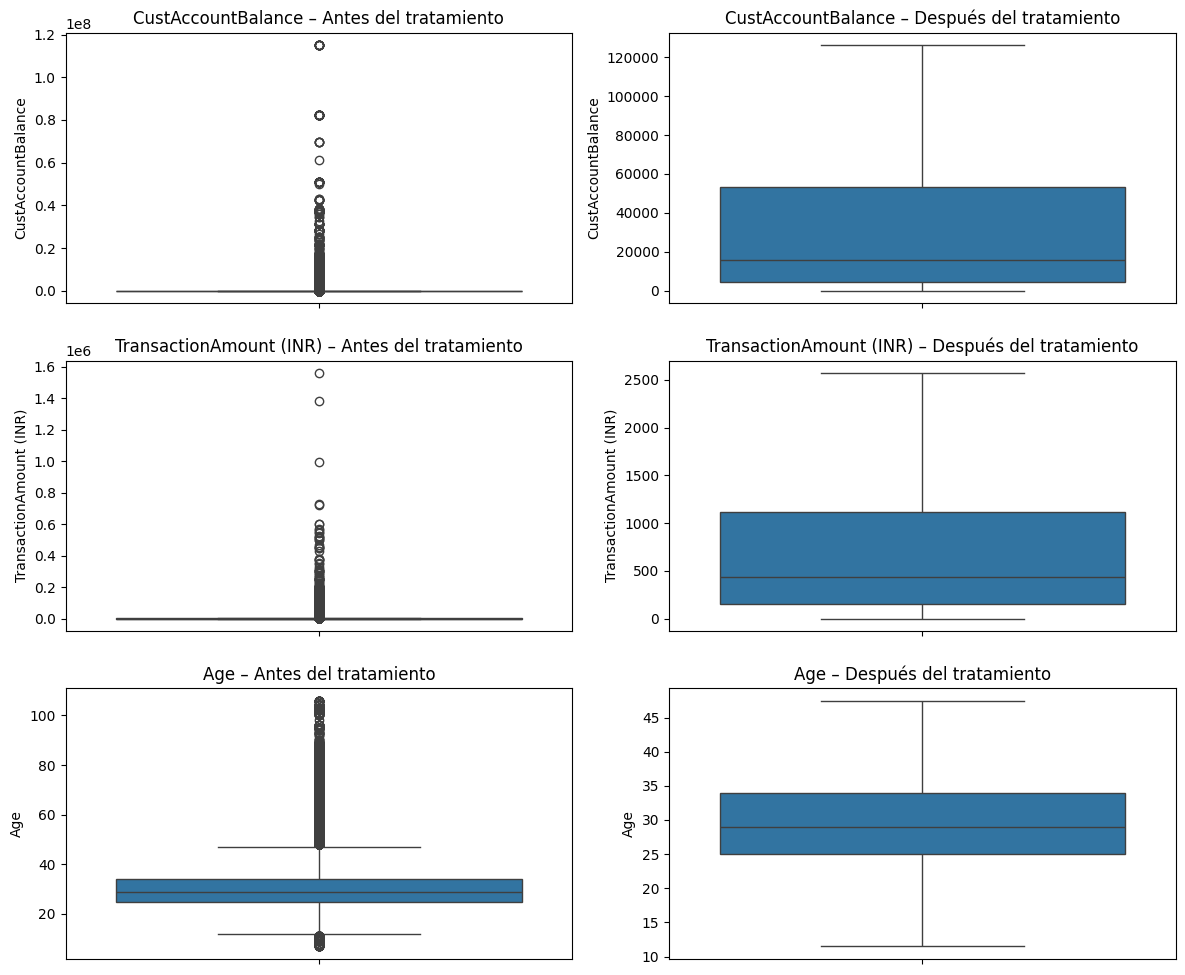

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
for i, col in enumerate(num_cols):
    sns.boxplot(y=cleaned_before[col], ax=axes[i, 0])
    axes[i, 0].set_title(f"{col} – Antes del tratamiento")
    sns.boxplot(y=cleaned[col], ax=axes[i, 1])
    axes[i, 1].set_title(f"{col} – Después del tratamiento")
plt.tight_layout()
plt.show()


El tratamiento de outliers en **cleaned_dataset.csv** permitió estabilizar las variables financieras más relevantes del conjunto de datos, corrigiendo valores extremos sin eliminar información útil. Se aplicó el método IQR con *capping*, logrando reducir balances y montos de transacción fuera de escala, y acotando edades a un rango realista. Este proceso mejoró la consistencia estadística y la representatividad del dataset, garantizando una base más limpia y confiable para análisis posteriores de comportamiento, segmentación y detección de fraude.

#### 4) cleaned_dataset

In [42]:
print("Shape:", agg.shape)
agg.info()

Shape: (838370, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838370 entries, 0 to 838369
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             838370 non-null  int64  
 1   CustomerID             838370 non-null  object 
 2   txn_count              838370 non-null  int64  
 3   total_spent            838370 non-null  float64
 4   avg_spent              838370 non-null  float64
 5   max_spent              838370 non-null  float64
 6   avg_balance            838370 non-null  float64
 7   first_txn_date         838370 non-null  object 
 8   last_txn_date          838370 non-null  object 
 9   location               838366 non-null  object 
 10  gender                 838370 non-null  object 
 11  recency_days           838370 non-null  int64  
 12  tenure_days            838370 non-null  int64  
 13  txn_per_day            838370 non-null  float64
 14  avg_spent_pct_ba

Se seleccionan las columnas pertinentes para realizar el tratamiento

In [44]:
num_cols = ['txn_count', 'total_spent', 'avg_spent', 'max_spent',
             'avg_balance', 'recency_days', 'tenure_days', 'txn_per_day']
agg[num_cols].describe()

,txn_count,total_spent,avg_spent,max_spent,avg_balance,recency_days,tenure_days,txn_per_day
count,838370.000000,8.383700e+05,8.383700e+05,8.383700e+05,8.383700e+05,838370.000000,838370.000000,838370.000000
mean,1.174001,1.691191e+03,1.441358e+03,1.623042e+03,1.036515e+05,55.419423,2.811600,0.892702
std,0.434824,6.625500e+03,5.983405e+03,6.565951e+03,7.782166e+05,15.221597,8.336134,0.308001
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.024691
25%,1.000000,1.980000e+02,1.794000e+02,1.940000e+02,5.372480e+03,43.000000,0.000000,1.000000
50%,1.000000,5.000000e+02,4.720000e+02,5.000000e+02,1.753242e+04,55.000000,0.000000,1.000000
75%,1.000000,1.408000e+03,1.169450e+03,1.305487e+03,5.665578e+04,68.000000,0.000000,1.000000
max,6.000000,1.560035e+06,1.560035e+06,1.560035e+06,1.150355e+08,81.000000,81.000000,3.000000


Vizualizamos cómo se comportan antes de la corrección 

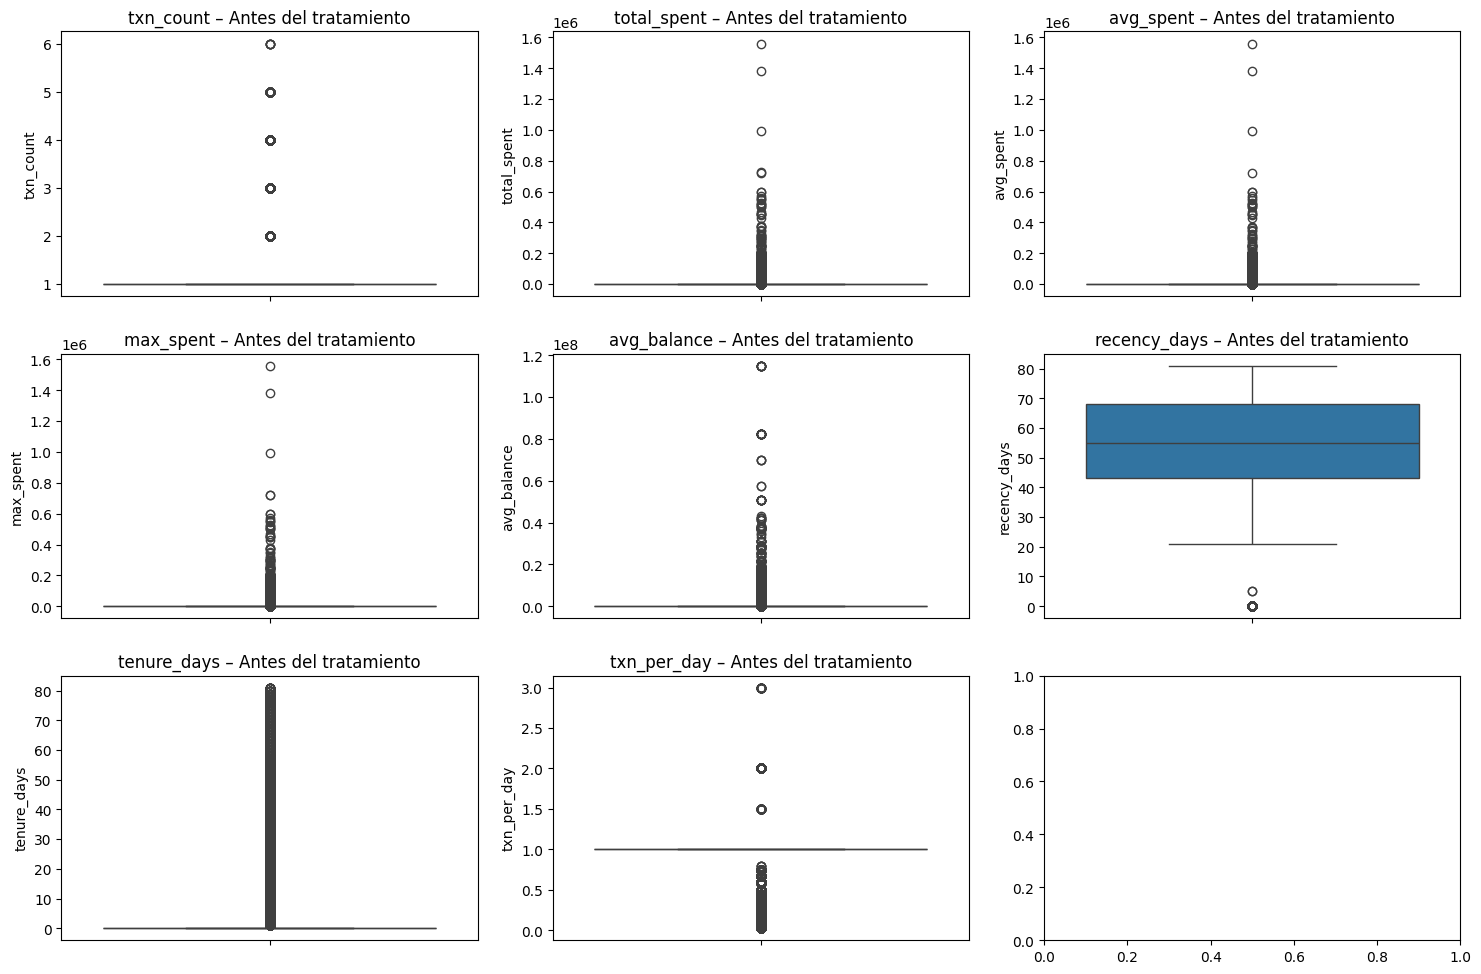

In [45]:
fig, axes = plt.subplots(3, 3, figsize=(15,10))
axes = axes.flatten()
for i, col in enumerate(num_cols[:9]):
    sns.boxplot(y=agg[col], ax=axes[i])
    axes[i].set_title(f"{col} – Antes del tratamiento")
plt.tight_layout()
plt.show()


Se aplica capping con IQR

In [46]:
agg_before = agg.copy()

def cap_iqr(df, col, k=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    df[col] = np.clip(df[col], lower, upper)
    return df, (lower, upper)

for col in num_cols:
    agg, limits = cap_iqr(agg, col)
    print(f"{col}: límites aplicados {limits}")


txn_count: límites aplicados (np.float64(1.0), np.float64(1.0))
total_spent: límites aplicados (np.float64(-1617.0), np.float64(3223.0))
avg_spent: límites aplicados (np.float64(-1305.675), np.float64(2654.525))
max_spent: límites aplicados (np.float64(-1473.2312499999998), np.float64(2972.71875))
avg_balance: límites aplicados (np.float64(-71552.47000000002), np.float64(133580.73))
recency_days: límites aplicados (np.float64(5.5), np.float64(105.5))
tenure_days: límites aplicados (np.float64(0.0), np.float64(0.0))
txn_per_day: límites aplicados (np.float64(1.0), np.float64(1.0))


Se contrastan los resultados obtenidos y cuántos en realidad fueron ajustados

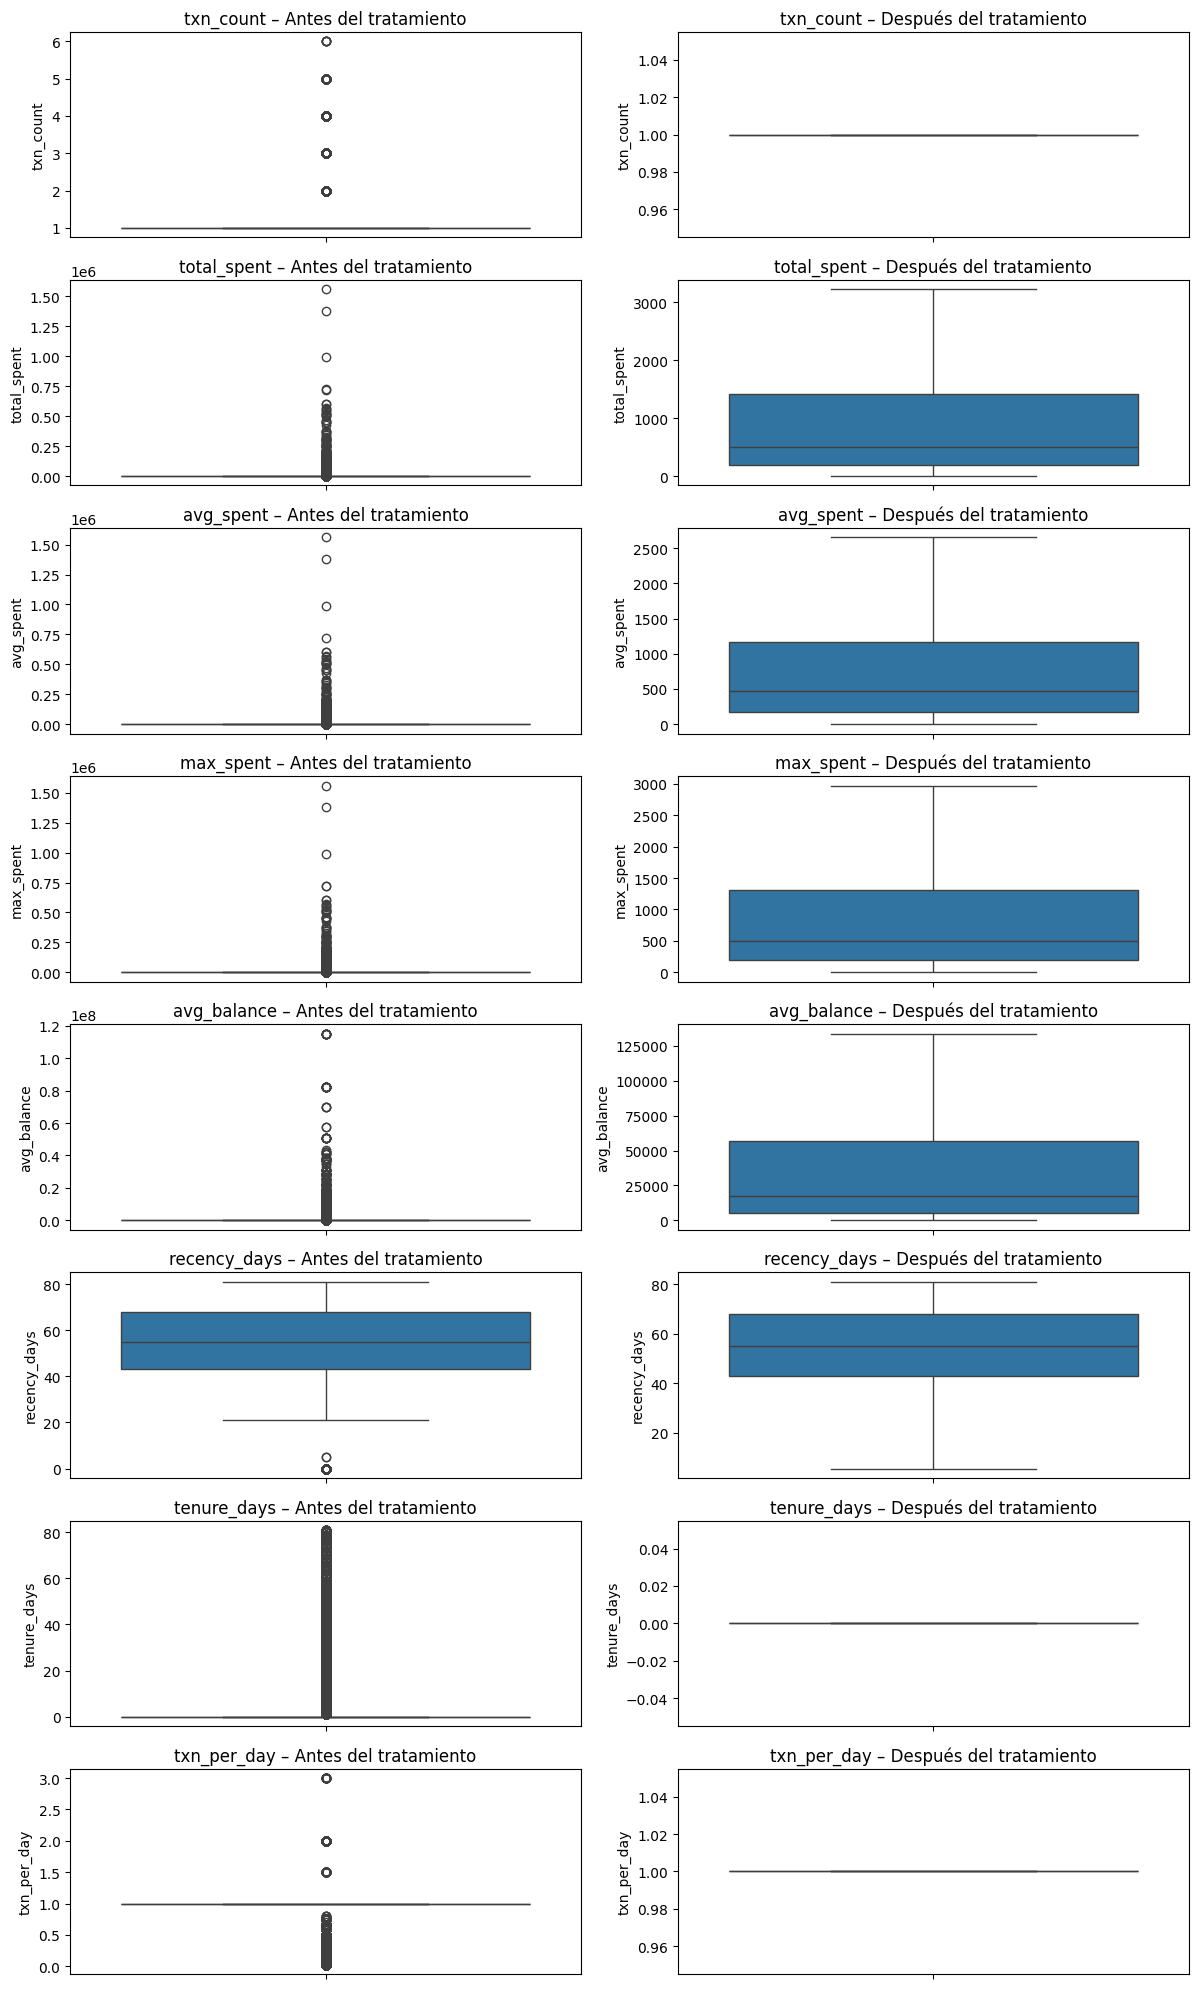

txn_count: 128568 valores ajustados (15.34%)
total_spent: 85724 valores ajustados (10.23%)
avg_spent: 86923 valores ajustados (10.37%)
max_spent: 88856 valores ajustados (10.60%)
avg_balance: 109507 valores ajustados (13.06%)
recency_days: 3402 valores ajustados (0.41%)
tenure_days: 126297 valores ajustados (15.06%)
txn_per_day: 124203 valores ajustados (14.81%)


In [48]:
fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 20))
for i, col in enumerate(num_cols):
    sns.boxplot(y=agg_before[col], ax=axes[i, 0])
    axes[i, 0].set_title(f"{col} – Antes del tratamiento")
    sns.boxplot(y=agg[col], ax=axes[i, 1])
    axes[i, 1].set_title(f"{col} – Después del tratamiento")
plt.tight_layout()
plt.show()

for col in num_cols:
    cambios = (agg_before[col] != agg[col]).sum()
    pct = 100 * cambios / len(agg)
    print(f"{col}: {cambios} valores ajustados ({pct:.2f}%)")


- Se redujo la varianza causada por casos extremos, mejorando la **consistencia estadística** del dataset.  
- Las variables mantienen su significado de negocio sin sesgos por clientes con comportamientos fuera de rango.  
- El conjunto de datos resultante es **más estable, representativo y confiable** para análisis de correlaciones, segmentaciones RFM o modelos predictivos de fraude.

Por lo que el tratamiento de *outliers* en *customer_agg.csv* consolidó un conjunto de métricas limpias y comparables entre clientes, mejorando la calidad y la interpretabilidad de la información agregada.  

Concluyendo esta cosa de aquí aplicado limpieza de Outliers a los cuatro datasets principales (fraud_dataset, RFM, cleaned_dataset y customer_agg) permitió corregir valores extremos en variables financieras, demográficas y de comportamiento, mejorando la estabilidad y representatividad de los datos sin eliminar registros. Mediante el método IQR con capping, se redujeron montos y balances fuera de escala, edades irreales y transacciones atípicas, obteniendo distribuciones más consistentes y comparables. Este proceso garantiza una base de datos limpia, confiable y estadísticamente equilibrada, apta para las etapas posteriores de análisis, segmentación y modelado de fraude.